# Libraries

In [1]:
import sys
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install xgboost --upgrade
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import exists
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import scipy.sparse as sp
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pacomoguel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

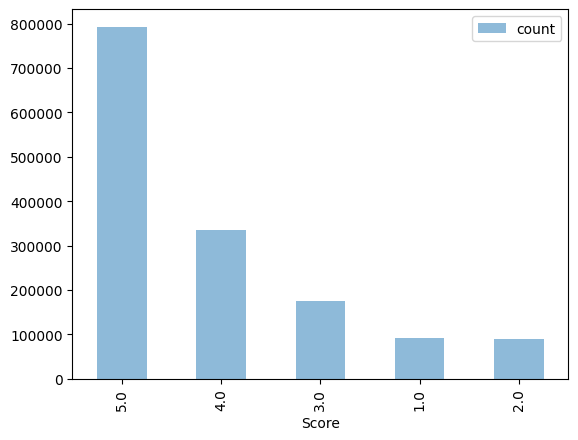


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
sid = SentimentIntensityAnalyzer()

def add_features_to(df):
    # This is where you can do all your feature extraction
    # Helpfulness features
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    # Text features
    df['ReviewLength'] = df['Text'].fillna('').apply(len)
    df['SentimentScoreText'] = df['Text'].fillna('').apply(lambda text: sid.polarity_scores(text)['compound'])
    # Time-based features
    df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year
    df['Month'] = pd.to_datetime(df['Time'], unit='s').dt.month
    df['DayOfWeek'] = pd.to_datetime(df['Time'], unit='s').dt.dayofweek
    df['ReviewAge'] = 2024 - df['Year']  # Assuming 2024 as current year
    # Additional features based on summary sentiment and punctuation count
    if 'Summary' in df.columns:
        df['SentimentScoreSummary'] = df['Summary'].fillna('').apply(lambda text: sid.polarity_scores(text)['compound'])
    df['QuestionCount'] = df['Text'].fillna('').apply(lambda text: text.count('?'))
    df['ExclamationCount'] = df['Text'].fillna('').apply(lambda text: text.count('!'))
    df['MeanRatingForMovie'] = df.groupby('ProductId')['Score'].transform('mean')

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# LSA Implementtaion

In [4]:
# TF-IDF and LSA Feature Extraction (BEFORE splitting into train/test sets)

# Initialize TF-IDF with bigrams
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, stop_words='english')

# Apply TF-IDF on training set (full X_train before split)
tfidf_matrix_train = tfidf.fit_transform(X_train['Text'].fillna(''))
tfidf_matrix_submission = tfidf.transform(X_submission['Text'].fillna(''))

# Apply LSA (SVD) to reduce dimensionality
lsa = TruncatedSVD(n_components=150, random_state=42)
lsa_features_train = lsa.fit_transform(tfidf_matrix_train)
lsa_features_submission = lsa.transform(tfidf_matrix_submission)

# Concatenate LSA features to the DataFrame
lsa_train_df = pd.DataFrame(lsa_features_train, columns=[f'LSA_{i}' for i in range(lsa_features_train.shape[1])], index=X_train.index)
lsa_submission_df = pd.DataFrame(lsa_features_submission, columns=[f'LSA_{i}' for i in range(lsa_features_submission.shape[1])], index=X_submission.index)

# Merge LSA features into X_train and X_submission
X_train = pd.concat([X_train, lsa_train_df], axis=1)
X_submission = pd.concat([X_submission, lsa_submission_df], axis=1)


# Sample + Split into training and testing set

In [5]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [6]:
# Define features to use
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'ReviewLength', 'SentimentScoreText',
            'Year', 'Month', 'DayOfWeek', 'ReviewAge', 'SentimentScoreSummary', 
            'QuestionCount', 'ExclamationCount', 'MeanRatingForMovie'] + [f'LSA_{i}' for i in range(150)]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Sampling

In [7]:
# Apply SMOTE to oversample the minority classes
oversample = SMOTE(random_state=42)
X_train_balanced, Y_train_balanced = oversample.fit_resample(X_train_select, Y_train)

# Check the class distribution after oversampling
print(Y_train_balanced.value_counts())

Score
5.0    595120
2.0    595120
1.0    595120
4.0    595120
3.0    595120
Name: count, dtype: int64


# Model Creation

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set this to True if you want to perform hyperparameter tuning; otherwise, use predefined parameters
tune_hyperparameters = False

# Define default best parameters (if tuning is skipped)
default_params = {
    'learning_rate': 0.3,
    'gamma': 1,
    'class_weights': {1: 1, 2: 1.001, 3: 1.12, 4: 1.215, 5: 1.07}
}

# Track the best accuracy and parameters if tuning
best_accuracy = 0
best_params = default_params if not tune_hyperparameters else {}
best_model = None

if tune_hyperparameters:
    # Define parameter grids for learning_rate, gamma, and class weights
    learning_rates = [0.1, 0.3, 0.5]
    gammas = [0.8, 1, 1.2]
    class_weights_list = [
        {1: 1, 2: 1.003, 3: 1.15, 4: 1.3, 5: 1.08},
        {1: 1.2, 2: 1.15, 3: 1.25, 4: 1.3, 5: 1.08},
        {1: 1.1, 2: 1.05, 3: 1.2, 4: 1.35, 5: 1.1}
    ]

    # Adjust labels for XGBoost compatibility
    Y_train_balanced_shifted = Y_train_balanced.astype(int) - 1

    # Loop through each combination of parameters
    for lr in learning_rates:
        for gamma_val in gammas:
            for class_weights in class_weights_list:
                # Map the weights to the training labels
                sample_weights = Y_train_balanced.map(class_weights)

                # Initialize model with current parameter combination
                xgb_model = XGBClassifier(
                    n_estimators=300,
                    learning_rate=lr,
                    gamma=gamma_val,
                    n_jobs=-1,
                    random_state=42
                )

                # Train the model
                xgb_model.fit(X_train_balanced, Y_train_balanced_shifted, sample_weight=sample_weights)

                # Predict on the test set and adjust back to 1-5 range
                Y_test_predictions = xgb_model.predict(X_test_select) + 1

                # Calculate accuracy
                accuracy = accuracy_score(Y_test, Y_test_predictions)

                # Update the best parameters if current accuracy is higher
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'learning_rate': lr,
                        'gamma': gamma_val,
                        'class_weights': class_weights
                    }
                    best_model = xgb_model  # Store the best model

                print(f"Learning Rate: {lr}, Gamma: {gamma_val}, Class Weights: {class_weights} => Accuracy: {accuracy}")

    print("Best Accuracy:", best_accuracy)
    print("Best Parameters:", best_params)

else:
    # Use predefined parameters
    print("Using predefined parameters:", default_params)
    sample_weights = Y_train_balanced.map(default_params['class_weights'])
    Y_train_balanced_shifted = Y_train_balanced.astype(int) - 1

    # Train the XGBClassifier with predefined parameters
    best_model = XGBClassifier(
        n_estimators=200,
        learning_rate=default_params['learning_rate'],
        gamma=default_params['gamma'],
        n_jobs=-1,
        random_state=42
    )
    best_model.fit(X_train_balanced, Y_train_balanced_shifted, sample_weight=sample_weights)

# Evaluate the model on the test set
Y_test_predictions_best = best_model.predict(X_test_select) + 1

Using predefined parameters: {'learning_rate': 0.3, 'gamma': 1, 'class_weights': {1: 1, 2: 1.001, 3: 1.12, 4: 1.215, 5: 1.07}}


# Model Evaluation

Accuracy on testing set = 0.6179470883512507


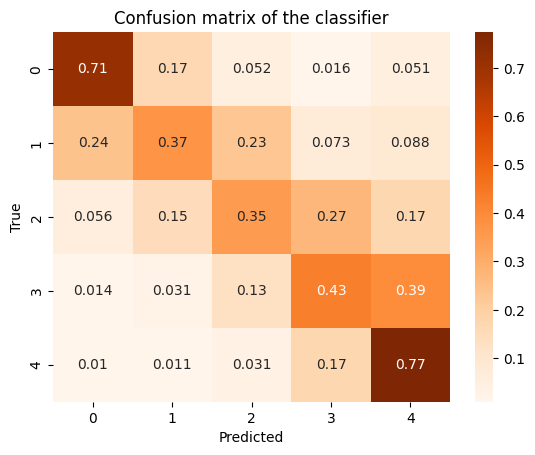

In [9]:
# Evaluate the best model
print("Accuracy on testing set =", accuracy_score(Y_test, Y_test_predictions_best))

# Plot the confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions_best, normalize='true')
sns.heatmap(cm, annot=True, cmap="Oranges")
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [10]:
# Use the best model to generate predictions for submission
X_submission['Score'] = best_model.predict(X_submission_select) + 1  # Shift predictions back to 1-5
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)